<img src="images/ARM_Logo.png" width=250 alt="Relampago_log"></img>

# Microphysical Aspects

### Imports 

In [22]:
from datetime import datetime, timedelta
from functools import partial
import numpy as np
import pandas as pd
import xarray as xr
import os
from datetime import datetime, timedelta
import act
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import imageio
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

### Download the disdrometer data
For chosen case,download the Disdrometer data from ARM site at Cordoba, use the required startdate and enddate, select the correct datastream.

In [23]:
username="dhwanit"
token="3921814e4c79c99d"
# Set the datastream and start/enddates    
datastream_disdro ='corldM1.b1'    #DISDRO
startdate = '2019-01-29'
enddate = '2019-01-29'

result1 = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)
result2 = act.discovery.download_arm_data(username, token, datastream_disdro, startdate, enddate)


[DOWNLOADING] cormwrlosM1.b1.20190129.000001.cdf

If you use these data to prepare a publication, please cite:

Cadeddu, M., & Tuftedal, M. Microwave Radiometer (MWRLOS). Atmospheric Radiation
Measurement (ARM) User Facility. https://doi.org/10.5439/1999490

[DOWNLOADING] corldM1.b1.20190129.000000.cdf

If you use these data to prepare a publication, please cite:

Wang, D., Bartholomew, M. J., Zhu, Z., & Shi, Y. Laser Disdrometer (LD).
Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1973058



### Read using xarray
Read the data

In [24]:
ds2=xr.open_dataset("/data/home/dhwanit/CACTI_Deep_Convection/corldM1.b1/corldM1.b1.20190129.000000.cdf")


### Plotting

Plotting Precipitation Intensity(mm/hr) to indentify the actual rainfall timings

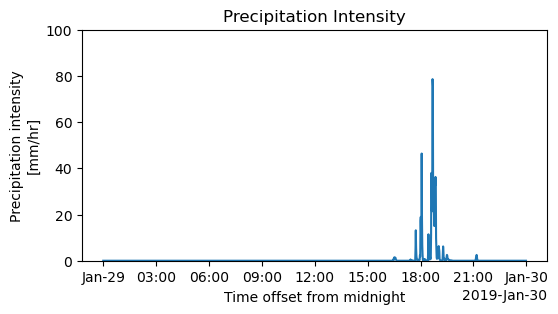

In [31]:
fig = plt.figure(figsize=(6, 3))
ds2.precip_rate.plot()
plt.title("Precipitation Intensity")
plt.ylim(0,100)
#plt.savefig("Precipitation_Intensity.png")
plt.show()


The higher precipitation Intensity indicates the presence of convective rainfall during 17:30 to 19:00 UTC,

Plot the Equivalent Reflectivity factor(Z) retrieved from the disdrodata

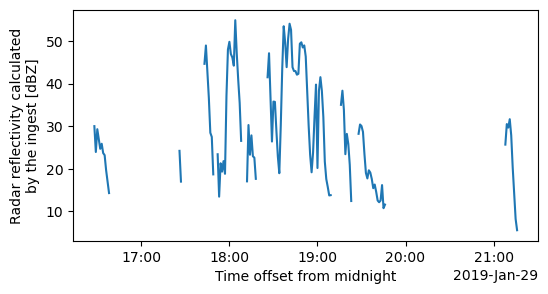

In [27]:

fig = plt.figure(figsize=(6, 3))
ds2.equivalent_radar_reflectivity.plot()

the peak Z values during the actual event indicates the presence of large sized droplets.

Plot the drop size distribution.

In [33]:
particle_size = ds2['particle_size'].values
time_slice = slice('2019-01-29T18:25:00', '2019-01-29T19:10:00')
number_density_drops_slice = ds2['number_density_drops'].sel(time=time_slice).mean(dim='time').values

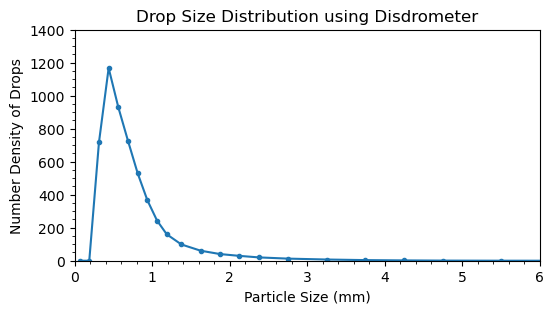

In [34]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(particle_size, number_density_drops_slice,marker=".")
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(0,6)  
#ax.set_ylim(1e-2, 1e4) 
ax.set_ylim(0,1400)
ax.minorticks_on()
plt.xlabel('Particle Size (mm)')
plt.ylabel('Number Density of Drops')
plt.title('Drop Size Distribution using Disdrometer')
plt.savefig("DSD.png")
plt.show()

## Mixing ratio profile from lasso

Selection of date, read all the Lasso data.

Plot the vertical sections of mixing ratios for all the files and create a Gif.

In [17]:
path_staging = "data/project/ARM_Summer_School_2024_Data/lasso_tutorial/cacti/lasso-cacti/20190129/eda09/base/les/subset_d3/"
file_pattern = "corlasso_met_*.nc"
full_pattern = os.path.join(path_staging, file_pattern)
# Get the list of matching files
matching_files = glob.glob(full_pattern)
# Loop through each file and plot Q2
for file in matching_files:
    ds = xr.open_dataset(file)
    if 'Q2' in ds.variables:
        ds['Q2'].plot()
        plt.title(f"Q2 from file: {os.path.basename(file)}")
        plt.show()
    else:
        print(f"'Q2' not found in file: {file}")


Vertical cross section of Mixing ratio from lasso.

Select the target datetime, start and end times of interest and longitude bounds.

The vertical section passes through the ARM deployment at Cordoba


In [ ]:

case_date = datetime(2019, 1, 29)
time_start = case_date + timedelta(hours=14)  # start time
time_end = case_date + timedelta(hours=20)  # end time
time_step = timedelta(minutes=15)  # time step interval
# Simulation selection within the case date:
ens_name = "eda09"
config_label = "base"
domain = 2
plot_lat = -(32.+(7./60.)+(35.076/3600.))  # latitude to sample

rootpath_wrf = "/data/project/ARM_Summer_School_2024_Data/lasso_tutorial/cacti/lasso-cacti"
scale = "meso" if domain < 3 else "les"
path_wrf_subset = f"{rootpath_wrf}/{case_date:%Y%m%d}/{ens_name}/{config_label}/{scale}/subset_d{domain}"
filename_stat = f"{path_wrf_subset}/corlasso_stat_{case_date:%Y%m%d}00{ens_name}d{domain}_{config_label}_M1.m1.{time_start:%Y%m%d.%H%M}00.nc"
ds_stat = xr.open_dataset(filename_stat)
lats = ds_stat["XLAT"]
lons = ds_stat["XLONG"]
nlat, nlon = lons.shape
abslat = np.abs(lats.isel(west_east=int(nlon/2)) - plot_lat)
jloc = np.argmin(abslat.values)
hgt = ds_stat["HGT"].isel(Time=0, south_north=jloc)  # terrain height along the cross section's swath
frames = []
# Loop through every time step
current_time = time_start
while current_time <= time_end:
    filename_met = f"{path_wrf_subset}/corlasso_met_{case_date:%Y%m%d}00{ens_name}d{domain}_{config_label}_M1.m1.{current_time:%Y%m%d.%H%M}00.nc"
    filename_cld = f"{path_wrf_subset}/corlasso_cld_{case_date:%Y%m%d}00{ens_name}d{domain}_{config_label}_M1.m1.{current_time:%Y%m%d.%H%M}00.nc"
    filename_cldhamsl = f"{path_wrf_subset}/corlasso_cldhamsl_{case_date:%Y%m%d}00{ens_name}d{domain}_{config_label}_M1.m1.{current_time:%Y%m%d.%H%M}00.nc"
    # Open datasets for each time step
    ds_met = xr.open_dataset(filename_met)
    ds_cld = xr.open_dataset(filename_cld)
    ds_cldhamsl = xr.open_dataset(filename_cldhamsl)
    # Select data for the current time step
    hamsl_raw = ds_met['HAMSL'].sel(Time=np.datetime64(f"{current_time:%Y-%m-%d %H:%M:%S}"), south_north=jloc)
    plotdata_hamsl = 1000. * (
        ds_cldhamsl['QCLOUD'].sel(Time=np.datetime64(f"{current_time:%Y-%m-%d %H:%M:%S}"), south_north=jloc) +
        ds_cldhamsl['QICE'].sel(Time=np.datetime64(f"{current_time:%Y-%m-%d %H:%M:%S}"), south_north=jloc)
    )
    
    fig, axs = plt.subplots(figsize=(11, 4))
    plotdata_hamsl.plot(ax=axs)
    plt.ylim(0, 12000)
    plt.title(f"Time: {current_time:%Y-%m-%d %H:%M}")
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(frame)
    # plt.close(fig) 
    # ds_met.close()
    # ds_cld.close()
    # ds_cldhamsl.close()
    current_time += time_step
# Save as a GIF
gif_filename = 'Mixing-ratio-variation.gif'
imageio.mimsave(gif_filename, frames, fps=4)
print(f"GIF saved as {gif_filename}")

<img src="Mixing-ratio-variation.gif" width=1000 alt="Relampago_log"></img>